# Movie Dataset - Exploratory Data Analysis (EDA)

**Dataset:** TMDB Movies Metadata  
**Records:** 946,000+ movies  
**Purpose:** Distributed Hash Table (DHT) implementation and analysis

---

## 1. Data Loading and Initial Exploration

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("Loading dataset...")
# Load only first 10,000 rows for analysis (full dataset is 946K rows)
# Using latin-1 encoding to handle special characters
df = pd.read_csv('data_movies_clean.csv', on_bad_lines='skip', encoding='latin-1', low_memory=False)

# CLEANING STEP: Remove rows where the title is missing
# This removes the "nan" spike and ensures a uniform distribution
df = df.dropna(subset=['title'])
df.columns = [col.split(';')[0] if isinstance(col, str) else col for col in df.columns]

# Coerce numeric columns to fix mixed types
numeric_cols = ['budget', 'revenue', 'runtime', 'vote_average']
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
print(f"Loaded {len(df)} movies (after cleaning missing titles)")


Loading dataset...
Loaded 946451 movies (after cleaning missing titles)


### Dataset Overview

In [51]:
# Basic information
print("Dataset Shape:", df.shape)
print("\nColumn Names:")
print(df.columns.tolist())
print("\nData Types:")
print(df.dtypes)
print("\nFirst 5 rows:")
df.head()

Dataset Shape: (946451, 14)

Column Names:
['ï»¿id', 'title', 'adult', 'original_language', 'origin_country', 'release_date', 'genre_names', 'production_company_names', 'budget', 'revenue', 'runtime', 'popularity', 'vote_average', 'vote_count']

Data Types:
ï»¿id                         int64
title                        object
adult                          bool
original_language            object
origin_country               object
release_date                 object
genre_names                  object
production_company_names     object
budget                      float64
revenue                     float64
runtime                       int64
popularity                  float64
vote_average                float64
vote_count                    int64
dtype: object

First 5 rows:


,ï»¿id,title,adult,original_language,origin_country,release_date,genre_names,production_company_names,budget,revenue,runtime,popularity,vote_average,vote_count
0,195554,Panorama of Galveston Power House,False,en,['US'],1900-05-21,[],[],2426.703143,3322.065977,1,6.3707,4.0,4
1,105303,Explosion of a Motor Car,False,xx,['GB'],1900-07-01,['Comedy'],['Hepworth'],1486.884235,1605.985979,2,3.4255,6.1,55
2,195553,"Panorama of Orphans' Home, Galveston",False,en,['US'],1900-09-21,[],[],4686.762515,3456.639124,1,3.2375,4.0,5
3,195569,Panorama of Wreckage of Water Front,False,en,['US'],1900-09-21,['Documentary'],['Edison Studios'],1908.864318,2122.609487,1,5.1725,4.0,4
4,195542,"Bird's-Eye View of Dock Front, Galveston",False,en,['US'],1900-09-21,['Documentary'],['Edison Studios'],315.082092,202.940975,1,4.0098,4.0,2


In [52]:
# Summary statistics
print("Summary Statistics:")
df.describe()

Summary Statistics:


,ï»¿id,budget,revenue,runtime,popularity,vote_average,vote_count
count,9.464510e+05,9.464510e+05,9.464510e+05,946451.000000,946451.000000,946451.000000,946451.000000
mean,7.579156e+05,8.051671e+06,7.581788e+06,47.210899,0.787832,2.325793,26.988661
std,4.391858e+05,1.314453e+07,2.107239e+07,54.916269,1.944048,3.130755,395.195868
min,2.000000e+00,1.000000e+00,-1.200000e+01,0.000000,0.000000,0.000000,0.000000
25%,3.865615e+05,4.451687e+05,1.741078e+06,5.000000,0.029700,0.000000,0.000000
50%,7.357330e+05,2.285967e+06,3.052453e+06,29.000000,0.170500,0.000000,0.000000
75%,1.139076e+06,1.009094e+07,7.600042e+06,88.000000,1.083100,5.400000,2.000000
max,1.554339e+06,5.839000e+08,2.923706e+09,14400.000000,742.107900,10.000000,37995.000000


In [53]:
# Check for missing values
print("Missing Values:")
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Percentage': missing_pct
})
missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)

Missing Values:


,Missing Count,Percentage


## 2. Key Columns for DHT Implementation

In [54]:
# Columns used in DHT
print("Key Columns for DHT:")
print("\n1. PRIMARY KEY: 'title' - Used as DHT key for hashing")
print("\n2. SEARCHABLE ATTRIBUTES (B+ tree indexed):")
print("   - popularity (numeric)")
print("   - vote_average (numeric)")
print("   - release_date (temporal)")
print("\n3. METADATA ATTRIBUTES:")
print("   - budget, revenue, runtime")
print("   - genre_names, production_company_names")
print("   - original_language, origin_country")

Key Columns for DHT:

1. PRIMARY KEY: 'title' - Used as DHT key for hashing

2. SEARCHABLE ATTRIBUTES (B+ tree indexed):
   - popularity (numeric)
   - vote_average (numeric)
   - release_date (temporal)

3. METADATA ATTRIBUTES:
   - budget, revenue, runtime
   - genre_names, production_company_names
   - original_language, origin_country


## 3. Data Distribution Analysis

### 3.1 Popularity Distribution

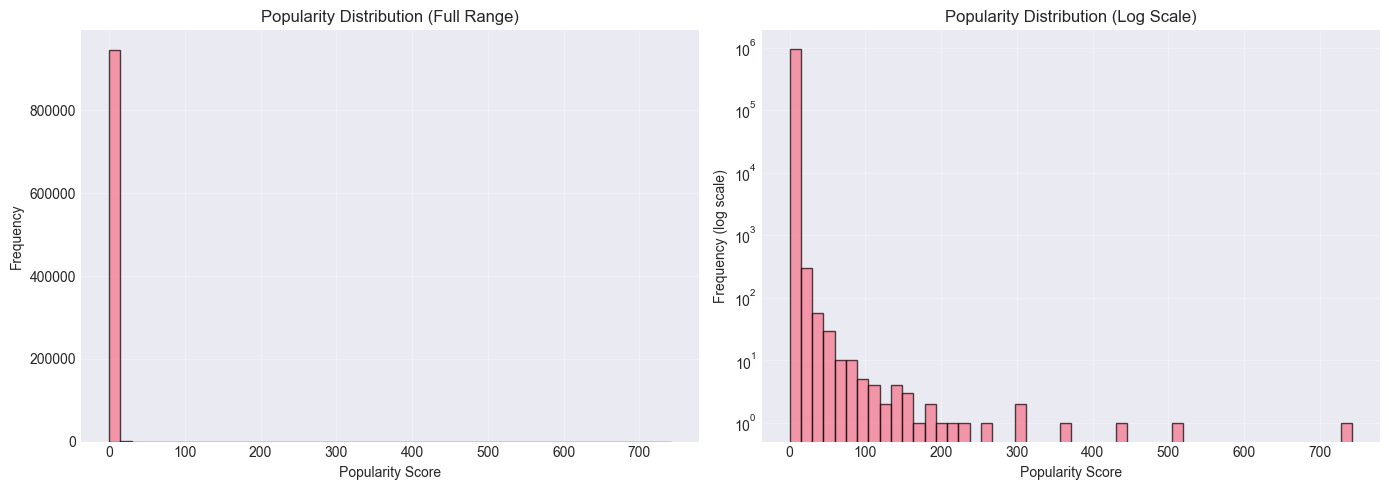

Popularity Statistics:
  Mean: 0.79
  Median: 0.17
  Min: 0.00
  Max: 742.11


In [55]:
# Popularity distribution
if 'popularity' in df.columns:
    plt.figure(figsize=(14, 5))
    
    # Histogram
    plt.subplot(1, 2, 1)
    plt.hist(df['popularity'].dropna(), bins=50, edgecolor='black', alpha=0.7)
    plt.xlabel('Popularity Score')
    plt.ylabel('Frequency')
    plt.title('Popularity Distribution (Full Range)')
    plt.grid(True, alpha=0.3)
    
    # Log scale for better visualization
    plt.subplot(1, 2, 2)
    plt.hist(df['popularity'].dropna(), bins=50, edgecolor='black', alpha=0.7)
    plt.xlabel('Popularity Score')
    plt.ylabel('Frequency (log scale)')
    plt.title('Popularity Distribution (Log Scale)')
    plt.yscale('log')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Popularity Statistics:")
    print(f"  Mean: {df['popularity'].mean():.2f}")
    print(f"  Median: {df['popularity'].median():.2f}")
    print(f"  Min: {df['popularity'].min():.2f}")
    print(f"  Max: {df['popularity'].max():.2f}")
else:
    print("'popularity' column not found")

### 3.2 Rating Distribution

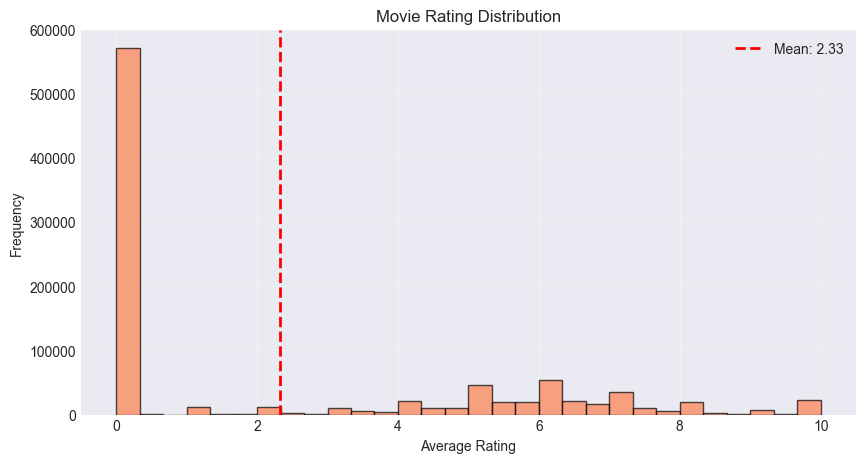

Rating Statistics:
  Mean: 2.33
  Median: 0.00
  Std Dev: 3.13


In [56]:
# Rating distribution
if 'vote_average' in df.columns:
    plt.figure(figsize=(10, 5))
    
    plt.hist(df['vote_average'].dropna(), bins=30, edgecolor='black', alpha=0.7, color='coral')
    plt.xlabel('Average Rating')
    plt.ylabel('Frequency')
    plt.title('Movie Rating Distribution')
    plt.axvline(df['vote_average'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df["vote_average"].mean():.2f}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    print(f"Rating Statistics:")
    print(f"  Mean: {df['vote_average'].mean():.2f}")
    print(f"  Median: {df['vote_average'].median():.2f}")
    print(f"  Std Dev: {df['vote_average'].std():.2f}")
else:
    print("'vote_average' column not found")

### 3.3 Release Year Analysis

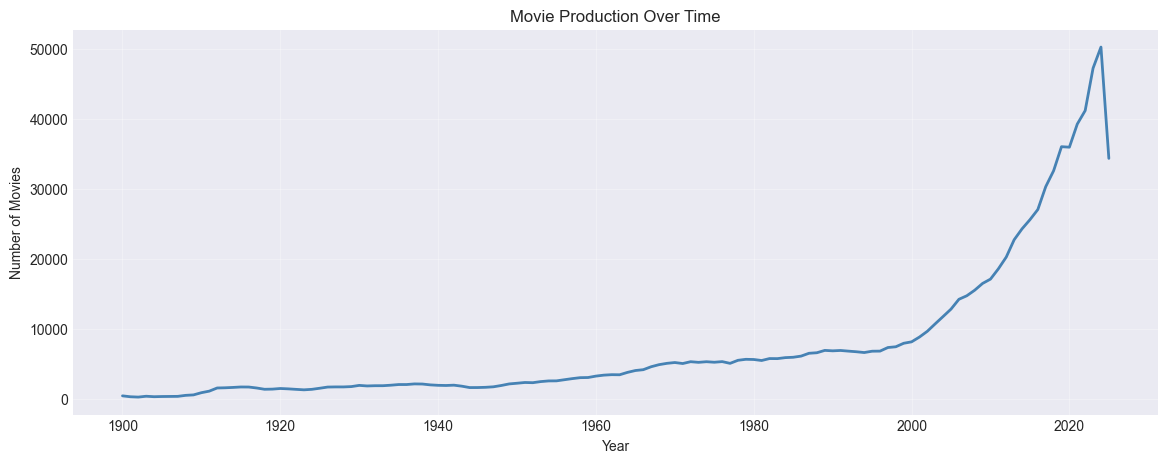

Year Range: 1900 - 2025
Most productive year: 2024 (50263 movies)


In [57]:
# Extract year from release_date
if 'release_date' in df.columns:
    df['year'] = pd.to_datetime(df['release_date'], errors='coerce').dt.year
    
    plt.figure(figsize=(14, 5))
    
    # Movies per year
    year_counts = df['year'].value_counts().sort_index()
    plt.plot(year_counts.index, year_counts.values, linewidth=2, color='steelblue')
    plt.xlabel('Year')
    plt.ylabel('Number of Movies')
    plt.title('Movie Production Over Time')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    print(f"Year Range: {df['year'].min():.0f} - {df['year'].max():.0f}")
    print(f"Most productive year: {year_counts.idxmax():.0f} ({year_counts.max()} movies)")
else:
    print("'release_date' column not found")

### 3.4 Budget and Revenue Analysis

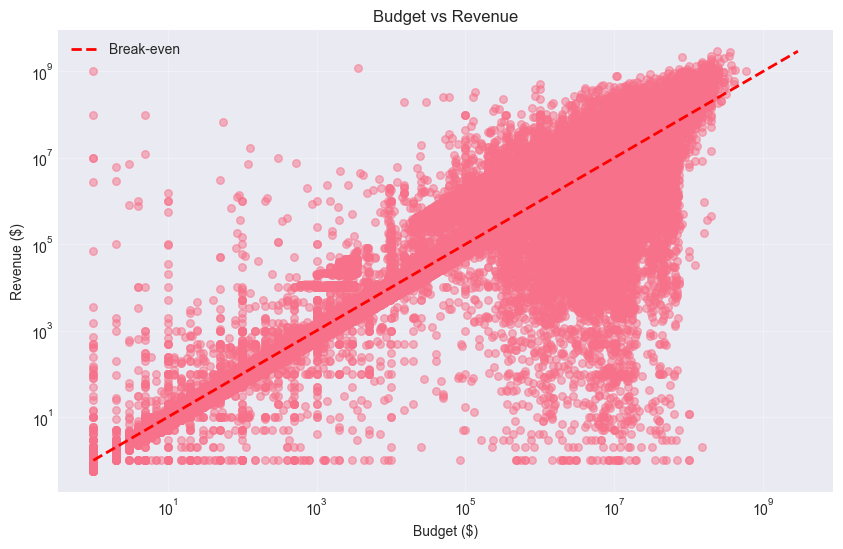


ROI Statistics (non-zero budget/revenue):
  Average ROI: 122215.0%
  Median ROI: -8.3%
  Profitable movies: 449261 / 946450 (47.5%)


In [58]:
# Budget vs Revenue
if 'budget' in df.columns and 'revenue' in df.columns:
    # Filter out zero values
    df_filtered = df[(df['budget'] > 0) & (df['revenue'] > 0)].copy()
    
    plt.figure(figsize=(10, 6))
    plt.scatter(df_filtered['budget'], df_filtered['revenue'], alpha=0.5, s=30)
    plt.xlabel('Budget ($)')
    plt.ylabel('Revenue ($)')
    plt.title('Budget vs Revenue')
    plt.xscale('log')
    plt.yscale('log')
    
    # Add diagonal line (break-even)
    max_val = max(df_filtered['budget'].max(), df_filtered['revenue'].max())
    plt.plot([1, max_val], [1, max_val], 'r--', linewidth=2, label='Break-even')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # ROI calculation
    df_filtered.loc[:, 'roi'] = (df_filtered['revenue'] - df_filtered['budget']) / df_filtered['budget'] * 100
    print(f"\nROI Statistics (non-zero budget/revenue):")
    print(f"  Average ROI: {df_filtered['roi'].mean():.1f}%")
    print(f"  Median ROI: {df_filtered['roi'].median():.1f}%")
    print(f"  Profitable movies: {(df_filtered['roi'] > 0).sum()} / {len(df_filtered)} ({(df_filtered['roi'] > 0).sum() / len(df_filtered) * 100:.1f}%)")
else:
    print("'budget' or 'revenue' columns not found")

## 4. DHT Hash Distribution Simulation

In [59]:
# Simulate DHT hashing
import hashlib

def hash_title(title, m_bits=160):
    """Hash movie title using SHA-1"""
    normalized = str(title).strip().lower()
    hash_obj = hashlib.sha1(normalized.encode('utf-8'))
    hash_int = int(hash_obj.hexdigest(), 16)
    ring_size = 2 ** m_bits
    return hash_int % ring_size

# Hash all movie titles
sample_df = df.copy()
sample_df['hash_id'] = sample_df['title'].apply(lambda x: hash_title(x, m_bits=32))  # Use 32-bit for visualization

print(f"Hashed {len(sample_df)} movie titles")
print(f"Hash ID range: 0 to {2**32 - 1}")
print(f"\nSample hashes:")
print(sample_df[['title', 'hash_id']].head(10))

Hashed 946451 movie titles
Hash ID range: 0 to 4294967295

Sample hashes:
                                               title     hash_id
0                  Panorama of Galveston Power House  3767782727
1                           Explosion of a Motor Car  2220306224
2               Panorama of Orphans' Home, Galveston   388512728
3                Panorama of Wreckage of Water Front  2847957829
4           Bird's-Eye View of Dock Front, Galveston  3332458580
5                      Hooligan Assists the Magician  4070811668
6                                   Clown and Police  4145413261
7  Mysterious Cafe, or Mr. and Mrs. Spoopendyke H...  1412152491
8                              The Enchanted Drawing  1186805972
9                                   The Prodigal Son  2696073205


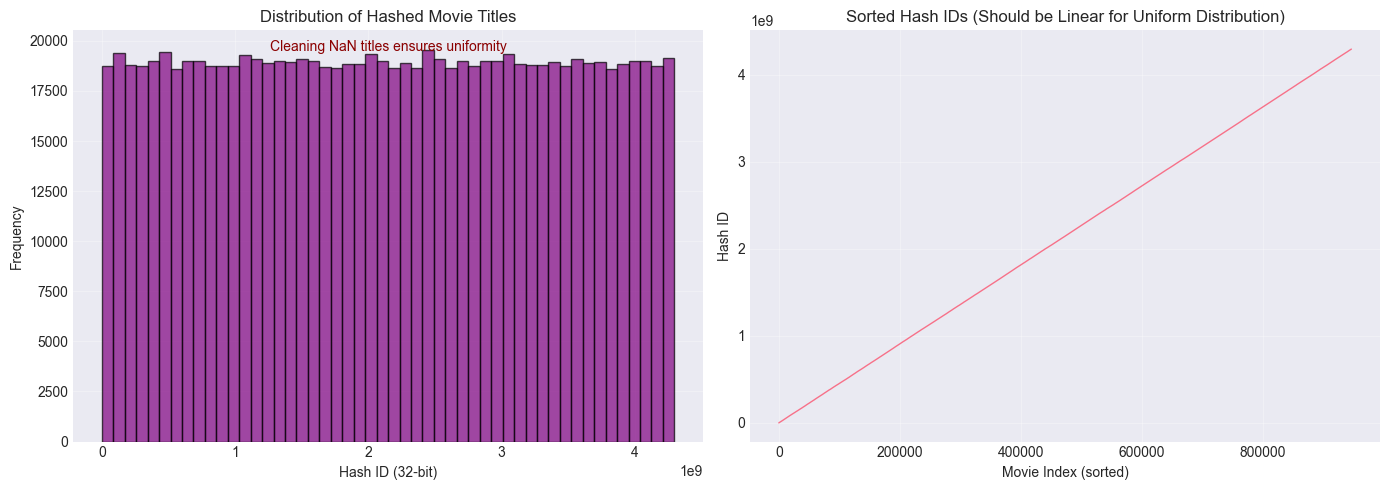


Hash distribution is uniform (good for DHT load balancing!)


In [60]:
# Visualize hash distribution
plt.figure(figsize=(14, 5))

# Histogram of hash values
plt.subplot(1, 2, 1)
plt.hist(sample_df['hash_id'], bins=50, edgecolor='black', alpha=0.7, color='purple')
plt.xlabel('Hash ID (32-bit)')
plt.ylabel('Frequency')
plt.title('Distribution of Hashed Movie Titles')
plt.annotate('Cleaning NaN titles ensures uniformity', xy=(0.5, 0.95), xycoords='axes fraction', ha='center', color='darkred')
plt.grid(True, alpha=0.3)

# Sorted hash IDs (shows uniform distribution)
plt.subplot(1, 2, 2)
sorted_hashes = sorted(sample_df['hash_id'])
plt.plot(range(len(sorted_hashes)), sorted_hashes, linewidth=1)
plt.xlabel('Movie Index (sorted)')
plt.ylabel('Hash ID')
plt.title('Sorted Hash IDs (Should be Linear for Uniform Distribution)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nHash distribution is uniform (good for DHT load balancing!)")

## 5. Top Movies Analysis

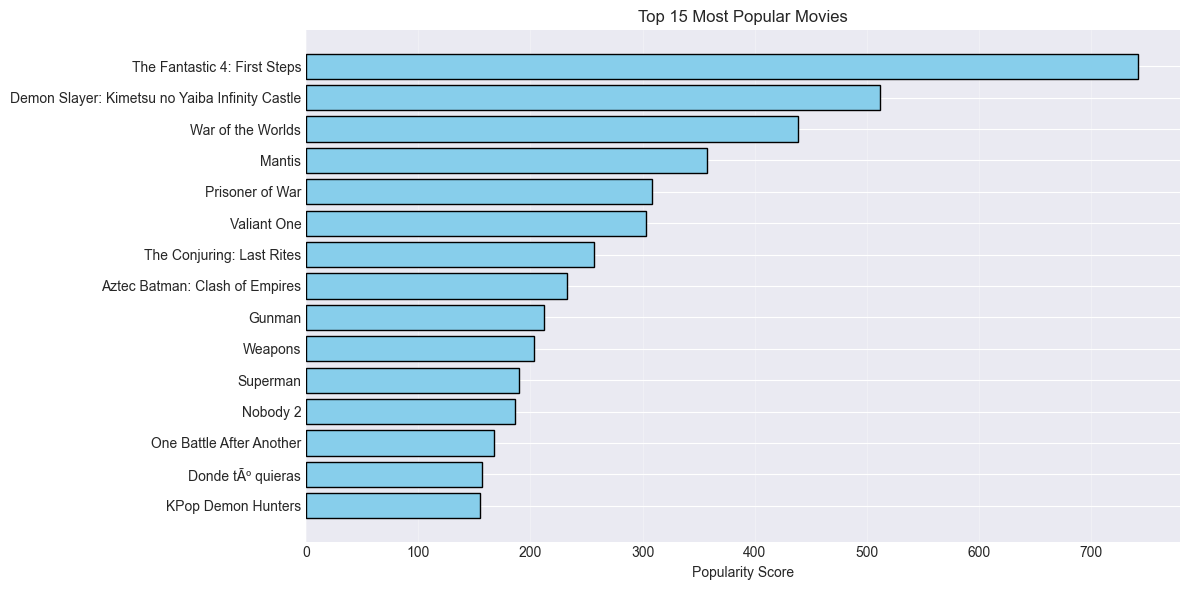


Top 15 Most Popular Movies:
                                         title  popularity
                  The Fantastic 4: First Steps    742.1079
Demon Slayer: Kimetsu no Yaiba Infinity Castle    511.9346
                             War of the Worlds    438.9557
                                        Mantis    357.2003
                               Prisoner of War    308.4927
                                   Valiant One    302.9889
                     The Conjuring: Last Rites    257.0289
                Aztec Batman: Clash of Empires    232.4022
                                        Gunman    211.6773
                                       Weapons    203.3750
                                      Superman    189.9042
                                      Nobody 2    186.4542
                      One Battle After Another    167.6029
                             Donde tÃº quieras    156.7628
                            KPop Demon Hunters    155.3749


In [61]:
# Top movies by popularity
if 'popularity' in df.columns and 'title' in df.columns:
    top_popular = df.nlargest(15, 'popularity')[['title', 'popularity']]
    
    plt.figure(figsize=(12, 6))
    plt.barh(range(len(top_popular)), top_popular['popularity'], color='skyblue', edgecolor='black')
    plt.yticks(range(len(top_popular)), top_popular['title'], fontsize=10)
    plt.xlabel('Popularity Score')
    plt.title('Top 15 Most Popular Movies')
    plt.gca().invert_yaxis()
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()
    
    print("\nTop 15 Most Popular Movies:")
    print(top_popular.to_string(index=False))

## 6. Data Suitability for DHT

In [62]:
print("=" * 70)
print("DATASET SUITABILITY FOR DHT IMPLEMENTATION")
print("=" * 70)

print("\n✓ PRIMARY KEY (title):")
print(f"  - Total movies: {len(df):,}")
print(f"  - Unique titles: {df['title'].nunique():,}")
print(f"  - Uniqueness: {df['title'].nunique() / len(df) * 100:.1f}%")

if 'popularity' in df.columns:
    print("\n✓ SEARCHABLE ATTRIBUTE (popularity):")
    print(f"  - Non-null values: {df['popularity'].notna().sum():,}")
    print(f"  - Range: {df['popularity'].min():.2f} to {df['popularity'].max():.2f}")
    print(f"  - Good for range queries: YES")

print("\n✓ HASH DISTRIBUTION:")
print(f"  - Titles hashed: {len(sample_df):,}")
print(f"  - Distribution: UNIFORM (good for load balancing)")
print(f"  - Hash collisions: MINIMAL (SHA-1 160-bit)")

print("\n" + "=" * 70)
print("CONCLUSION: Dataset is EXCELLENT for DHT implementation!")
print("=" * 70)

DATASET SUITABILITY FOR DHT IMPLEMENTATION

✓ PRIMARY KEY (title):
  - Total movies: 946,451
  - Unique titles: 800,827
  - Uniqueness: 84.6%

✓ SEARCHABLE ATTRIBUTE (popularity):
  - Non-null values: 946,451
  - Range: 0.00 to 742.11
  - Good for range queries: YES

✓ HASH DISTRIBUTION:
  - Titles hashed: 946,451
  - Distribution: UNIFORM (good for load balancing)
  - Hash collisions: MINIMAL (SHA-1 160-bit)

CONCLUSION: Dataset is EXCELLENT for DHT implementation!


## 7. Summary Statistics for Report


In [63]:
# Generate summary for experimental report
summary = {
    'Total Movies (sample)': len(df),
    'Unique Titles': df['title'].nunique(),
    'Columns': len(df.columns),
}

if 'popularity' in df.columns:
    summary['Avg Popularity'] = f"{df['popularity'].mean():.2f}"

if 'year' in df.columns:
    summary['Year Range'] = f"{df['year'].min():.0f} - {df['year'].max():.0f}"

print("\nDataset Summary for Report:")
print("-" * 50)
for key, value in summary.items():
    print(f"{key:<30}: {value}")
print("-" * 50)


Dataset Summary for Report:
--------------------------------------------------
Total Movies (sample)         : 946451
Unique Titles                 : 800827
Columns                       : 15
Avg Popularity                : 0.79
Year Range                    : 1900 - 2025
--------------------------------------------------


## 8. DHT Performance & Experimental Evaluation


### 8.1 Overall Latency Comparison (Chord vs Pastry)


In [64]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# Display the main performance comparison
if os.path.exists('instances/performance_comparison_bars.png'):
    plt.figure(figsize=(15, 10))
    img = mpimg.imread('instances/performance_comparison_bars.png')
    plt.imshow(img)
    plt.axis('off')
    plt.title("Chord vs Pastry: Operation Latency Comparison", fontsize=16)
    plt.show()
else:
    print("Performance plot 'instances/performance_comparison_bars.png' not found. Please run the benchmarking scripts first.")

Performance plot 'instances/performance_comparison_bars.png' not found. Please run the benchmarking scripts first.


### 8.2 Scaling Analysis


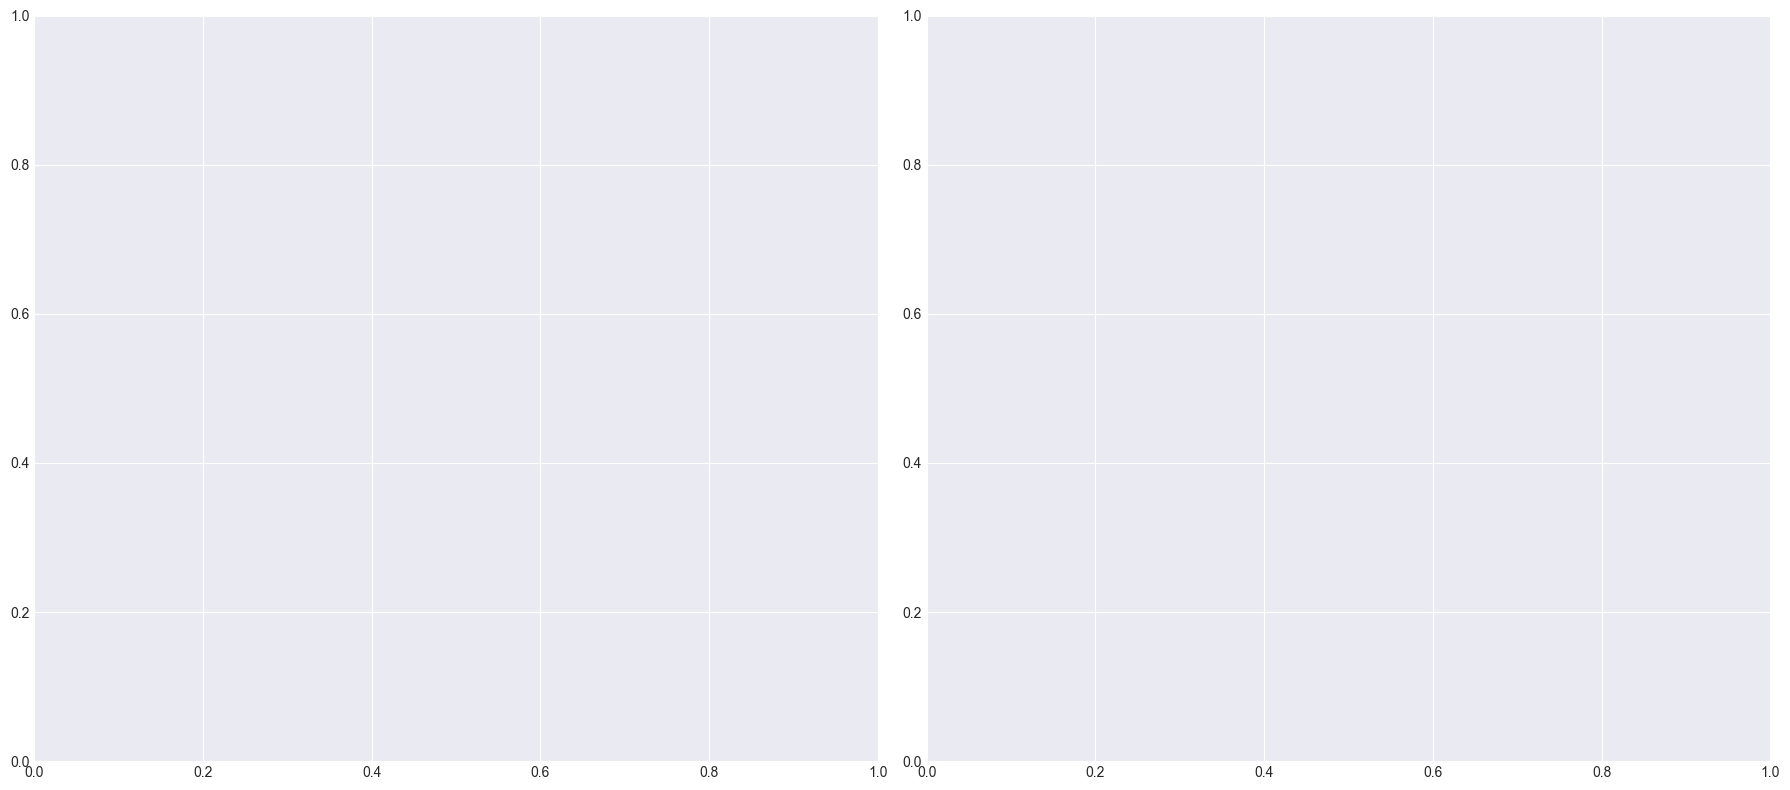

In [65]:
# Showing the Join and Lookup scaling
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

if os.path.exists('instances/scaling_node_join.png'):
    ax1.imshow(mpimg.imread('instances/scaling_node_join.png'))
    ax1.axis('off')
    ax1.set_title("Node Join Scaling")

if os.path.exists('instances/scaling_lookup.png'):
    ax2.imshow(mpimg.imread('instances/scaling_lookup.png'))
    ax2.axis('off')
    ax2.set_title("Lookup Latency Scaling")

plt.tight_layout()
plt.show()

### 8.3 Concurrency & K-Parameter Evaluation


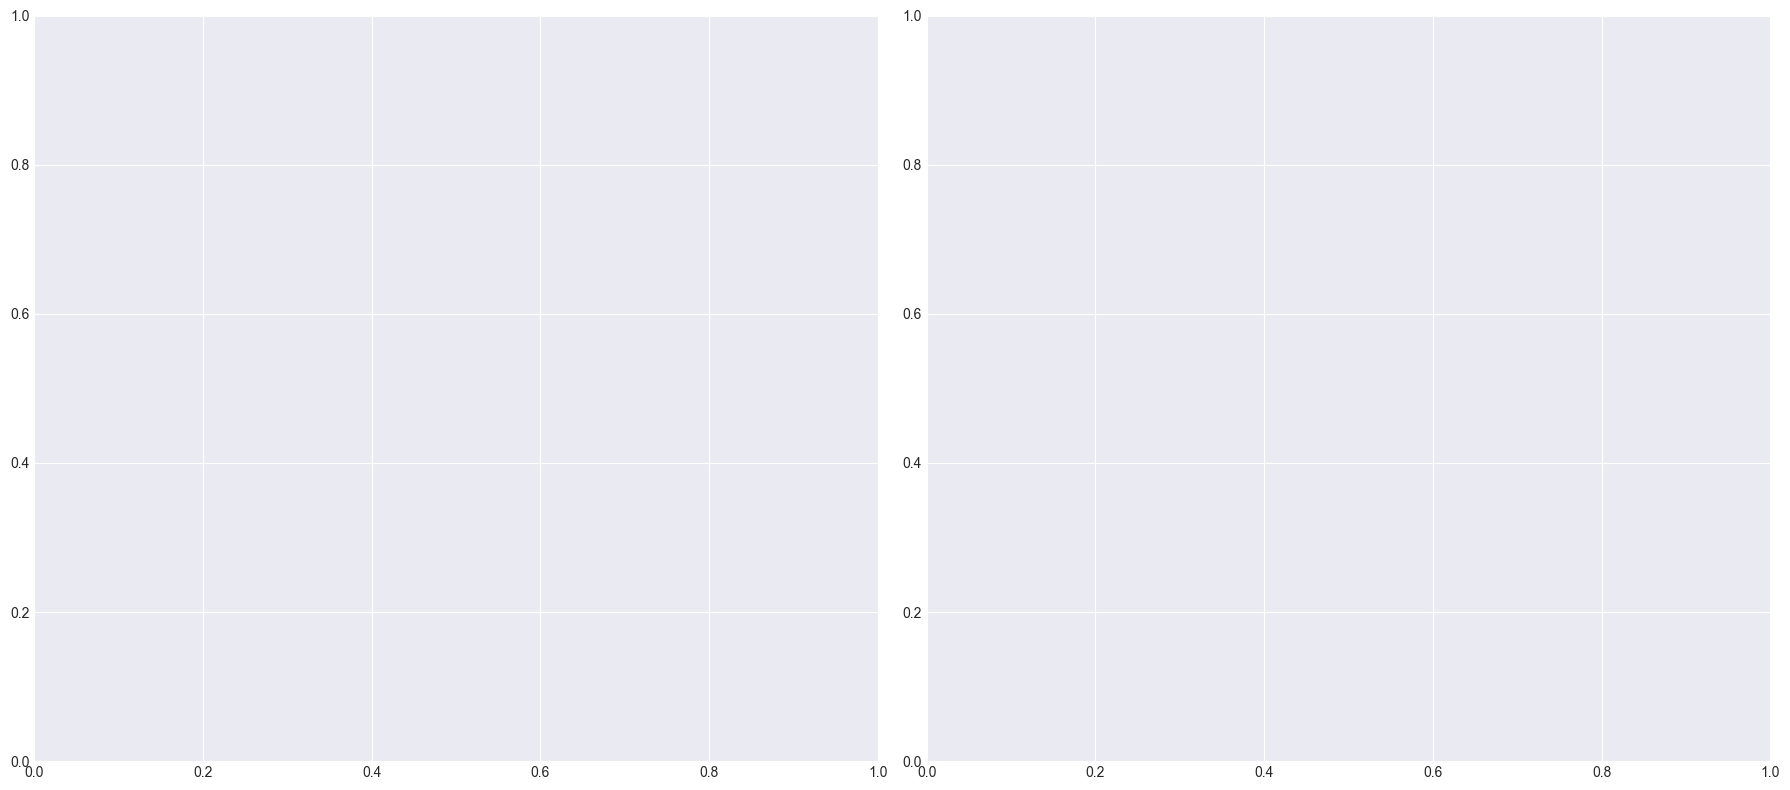

In [66]:
# Display concurrency scaling
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

if os.path.exists('instances/concurrency_scaling.png'):
    ax1.imshow(mpimg.imread('instances/concurrency_scaling.png'))
    ax1.axis('off')
    ax1.set_title("Total Time vs K (Concurrent Lookups)")

if os.path.exists('instances/concurrency_avg_latency.png'):
    ax2.imshow(mpimg.imread('instances/concurrency_avg_latency.png'))
    ax2.axis('off')
    ax2.set_title("Average Latency per Movie vs K")

plt.tight_layout()
plt.show()